In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K


In [2]:
import tensorflow as tf

# GPU 번호 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [3]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import Sequence
from skimage.transform import resize

data_dir = '/home2/kdh/vae'
image_folder = os.path.join(data_dir, 'img_align_celeba_4')

class CelebADataLoader(Sequence):
    def __init__(self, image_folder, batch_size, image_size=(24, 24), shuffle=True):
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_filenames = os.listdir(image_folder)
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))
    
    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        images = np.array([self.load_image(filename) for filename in batch_filenames])
        return images, images
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)
    
    def load_image(self, filename):
        img_path = os.path.join(self.image_folder, filename)
        img = load_img(img_path)
        img = img_to_array(img)
        img = resize(img, self.image_size, anti_aliasing=True)
        img = img / 255.0
        return img

batch_size = 9
image_size = (64, 64)
data_loader = CelebADataLoader(image_folder, batch_size, image_size)


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

# VAE 모델 정의
def build_vae(input_shape, latent_dim):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(16 * 16 * 64, activation='relu')(latent_inputs)
    x = Reshape((16, 16, 64))(x)
    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = Conv2DTranspose(input_shape[2], 3, activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, outputs, name='decoder')

    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')

    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
    reconstruction_loss *= input_shape[0] * input_shape[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    
    return encoder, decoder, vae

# 하이퍼파라미터 설정
image_size = (64, 64, 3)
latent_dim = 2

encoder, decoder, vae = build_vae(image_size, latent_dim)

vae.compile(optimizer='adam')

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.python.framework.ops import disable_eager_execution
# 데이터 로더 생성
callbacks=[]
data_loader = CelebADataLoader(image_folder, batch_size, image_size)

model_ckpt_name = "/home2/kdh/vae/vae_celeba_model/vae_celeba"
checkpoint = ModelCheckpoint(model_ckpt_name+'_ckpt.{epoch:02d}-{loss:.4f}.h5',
                                monitor='loss', 
                                verbose=1, save_best_only=True, mode='min')

# early stopping
patience = 500
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=patience, 
                            verbose=1, mode='min')
callbacks = [checkpoint, earlystop]
# 모델 학습
vae.fit(data_loader, epochs=5000, 
                        use_multiprocessing=True,
                        verbose=1,
                        callbacks=callbacks,
                        workers=48)

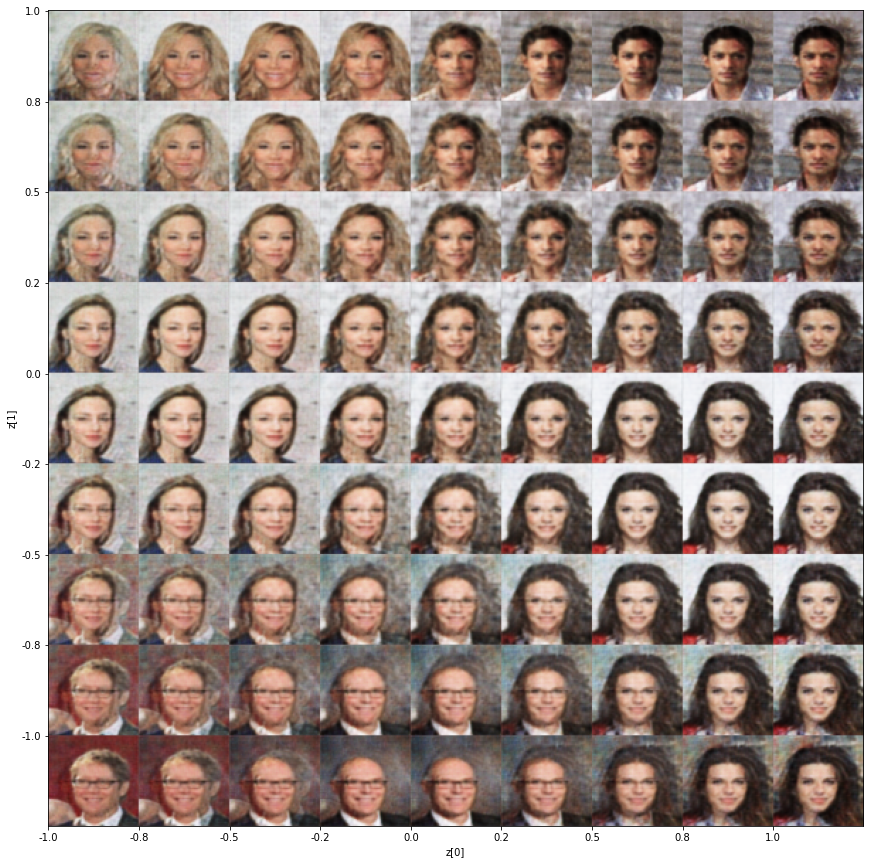

In [12]:
import matplotlib.pyplot as plt

def plot_latent_space(decoder, n=30, figsize=15):
    digit_size = 64
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    fixed_dims = np.zeros((1, latent_dim))
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi] + list(fixed_dims[0, 2:])])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(figsize, figsize))
    pixel_range = np.arange(0, n * digit_size, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent_space(decoder, n=9)